# Standardising Australia Hazard Maps

The goal of this notebook is to develop and provide examples of mapping climate hazards for Australia so that data can be consistently presented.
Examples will include maps for Australia and for selected states or regions.

In [1]:
import datetime
datetime.datetime.today().date()

datetime.date(2024, 9, 16)

In [2]:
# this code is designed to work with hh5 analysis3-24.04 venv
import sys
print(sys.executable)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/bin/python


In [3]:
cd /g/data/mn51/users/gt3409/


/g/data/mn51/users/gt3409


In [4]:
# cd /g/data/mn51/users/gt3409/plotting_maps/

# import packages used in this workflow


In [5]:
from plotting_maps.acs_plotting_maps import plot_acs_hazard, regions_dict, cmap_dict, tick_dict, plot_acs_hazard_3pp
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.cm as cm


# Suggested colormaps and scales

Using suggested colormaps and scales will improve the consistency across teams producing similar variables. This will support comparison across different plots.
- see many colormaps here: https://www.ncl.ucar.edu/Document/Graphics/color_table_gallery.shtml

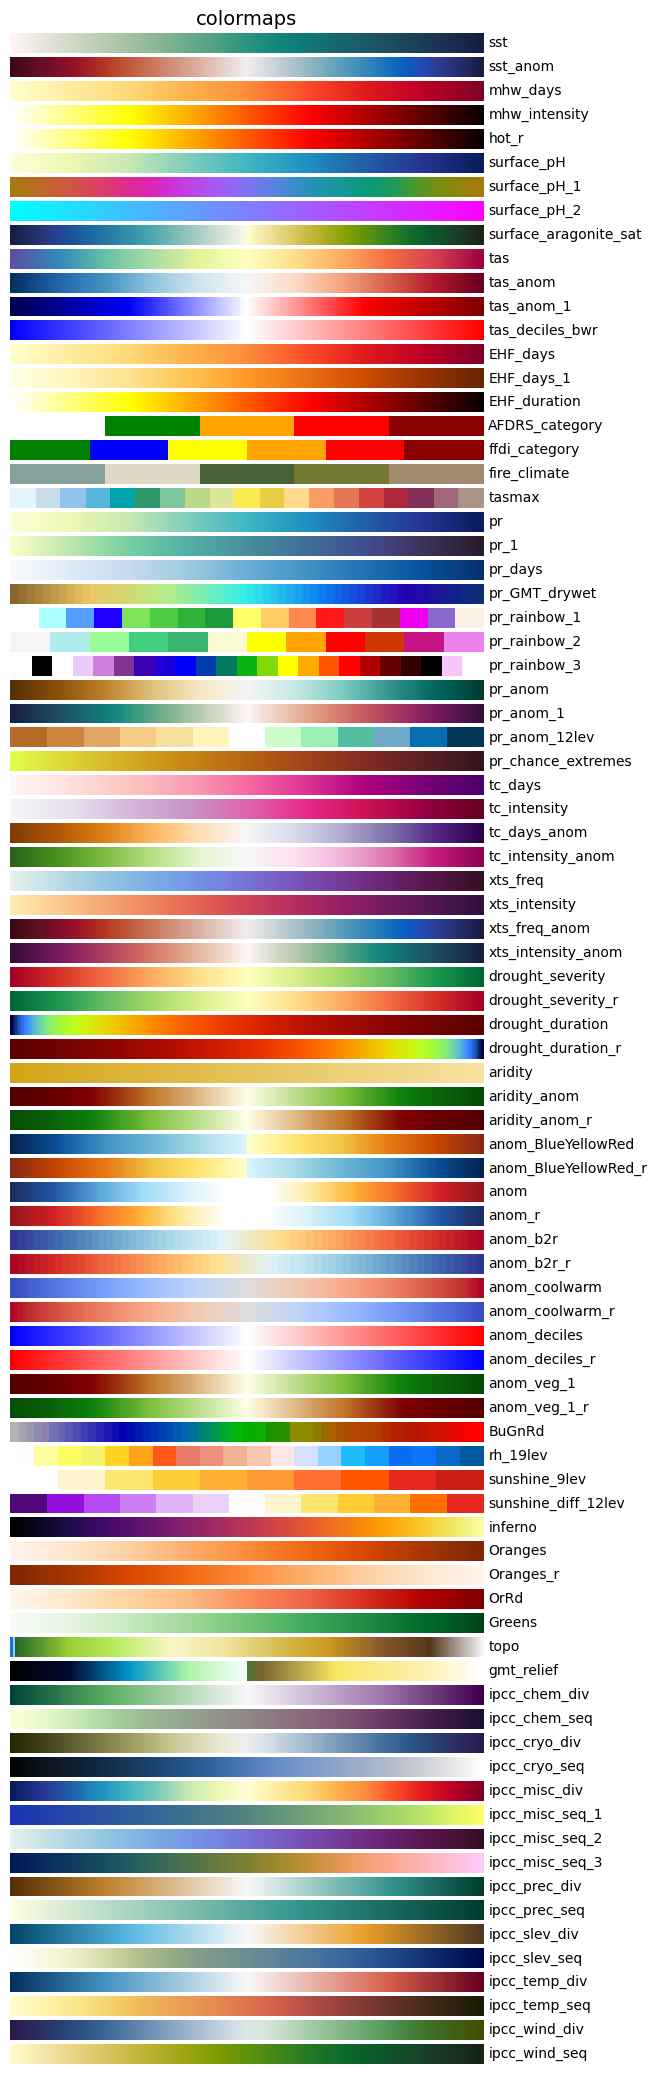

In [6]:
# visualise all the colormaps
nrows = len(cmap_dict)
figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
fig, axs = plt.subplots(nrows=nrows + 1, figsize=(6.4, figh),)
fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                    left=0.01, right=0.75)

gradient = np.vstack((np.linspace(0, 1, 256), np.linspace(0, 1, 256)))
for ax, name in zip(axs, list(cmap_dict.keys())):
    ax.imshow(gradient, aspect='auto', cmap=cmap_dict[name])
    ax.text(1.01, 0.5, name, va='center', ha='left', fontsize=10,
            transform=ax.transAxes)

# Turn off *all* ticks & spines, not just the ones with colormaps.
for ax in axs:
    ax.set_axis_off()

axs[0].set_title(f'colormaps', fontsize=14)

plt.savefig("colormaps_aus_maps.png",dpi=100,facecolor='lightgray',)

In [7]:
# This dictionary gives some suggestions on the scale of the colour map to use for some variables. The scales are taken from cliamte maps on bom.gov.au/climate
tick_dict.keys()
             

dict_keys(['pr_annual', 'pr_6mon', 'pr_3mon', 'pr_mon', 'pr_hour', 'pr_days', 'pr_anom_mon', 'pr_anom_3mon', 'pr_anom_6mon', 'pr_anom_ann', 'pr_diff_mon', 'pr_diff_ann', 'frost_days', 'frost_days_mon', 'tas', 'tas_anom_day', 'tas_anom_mon', 'tas_anom_ann', 'apparent_tas', 'percent', 'xts_freq', 'fire_climate_ticks', 'fire_climate_labels', 'aridity_index_ticks', 'aridity_index_labels'])

# Load the State and Region shape files

In [8]:
# write a dictionary of the shapefile geopandas dataframes. These will be used for state boundaries, LGAs, NRM, etc
regions_dict.keys()

    

dict_keys(['australia', 'ncra_regions'])

# Define single function for plotting maps

# Example plots

## Example 1: Australia map only
These plots show the state/ region borders without data

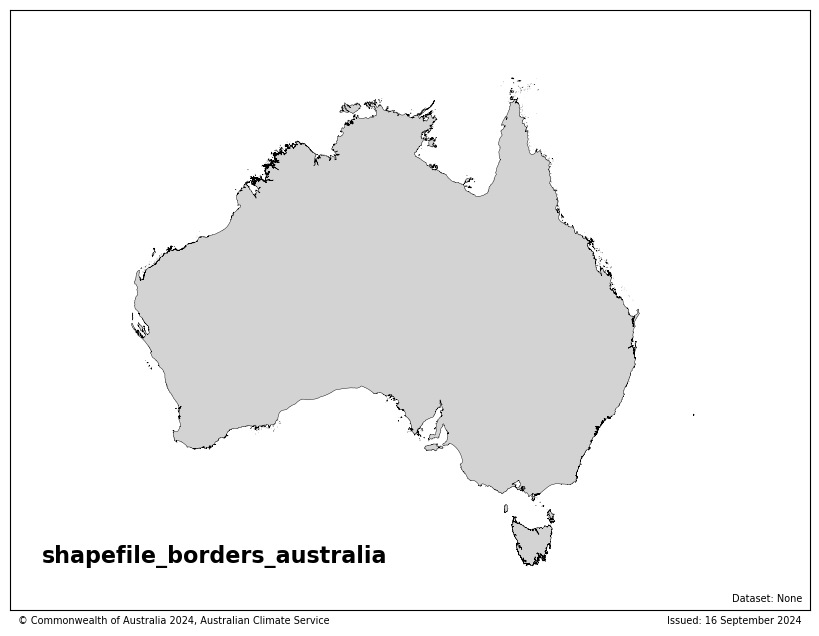

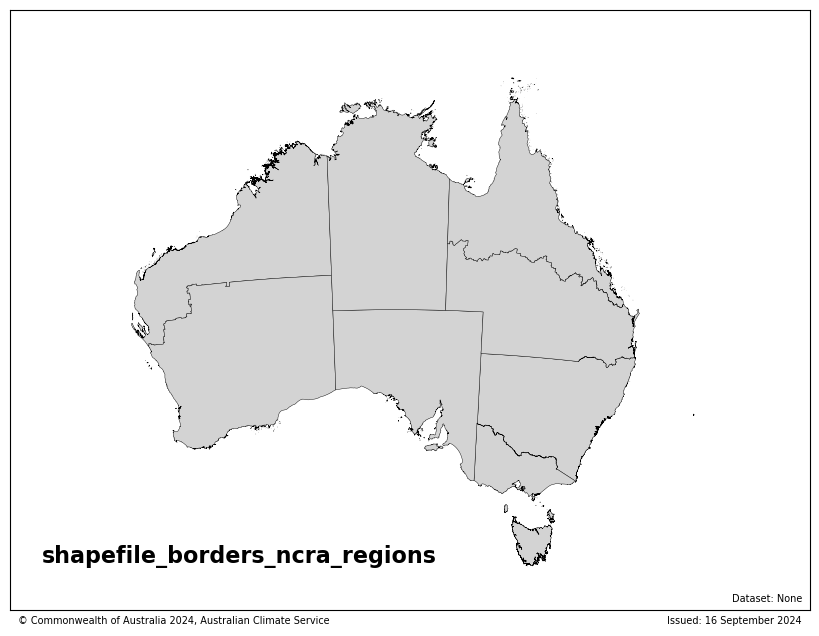

In [9]:
# Plot the shapefiles to see the borders

facecolor = "lightgrey"
xlim = (110,160)
ylim = (-45, -5)

for name in list(regions_dict.keys()):
    regions =  regions_dict[name]
    plot_acs_hazard(name = name,
                        regions = regions,
                        facecolor = facecolor, 
                        xlim = xlim,
                        ylim = ylim,
                        label_states = True,
                        title=f"shapefile_borders_{name}",
                        watermark=None);


## Examples with data
Load some temperature and rainfall data

In [10]:
# Load some hazard data

In [11]:
# load some rainfall data
ds_pr = xr.open_dataset("/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/bias-adjustment-input/AGCD-05i/BOM/ACCESS-CM2/historical/r4i1p1f1/BARPA-R/v1-r1/day/pr/pr_AGCD-05i_ACCESS-CM2_historical_r4i1p1f1_BOM_BARPA-R_v1-r1_day_19600101-19601231.nc")
# annual total rainfall
da_pr_ann = ds_pr.sum(dim="time").pr
# rainfall for one month
da_pr_jan = ds_pr.sel(time = ds_pr.time.dt.month==1).sum(dim="time").pr
# rainfall anomaly for one month
da_pr_anom = da_pr_jan-da_pr_ann/12


In [12]:
# load some temperature data
ds_tasmax = xr.open_dataset("/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/bias-adjustment-input/AGCD-05i/BOM/ACCESS-CM2/ssp370/r4i1p1f1/BARPA-R/v1-r1/day/tasmax/tasmax_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_BARPA-R_v1-r1_day_20150101-20151231.nc")
da_tasmax = ds_tasmax.tasmax.max(dim="time")
da_tasmax_anom = ds_tasmax.tasmax.max(dim="time") - ds_tasmax.tasmax.mean(dim="time")

## Example 2: Australia plots with data

State lines on Australia, with rainfall and temperature data

CPU times: user 2min 14s, sys: 1.07 s, total: 2min 15s
Wall time: 2min 16s


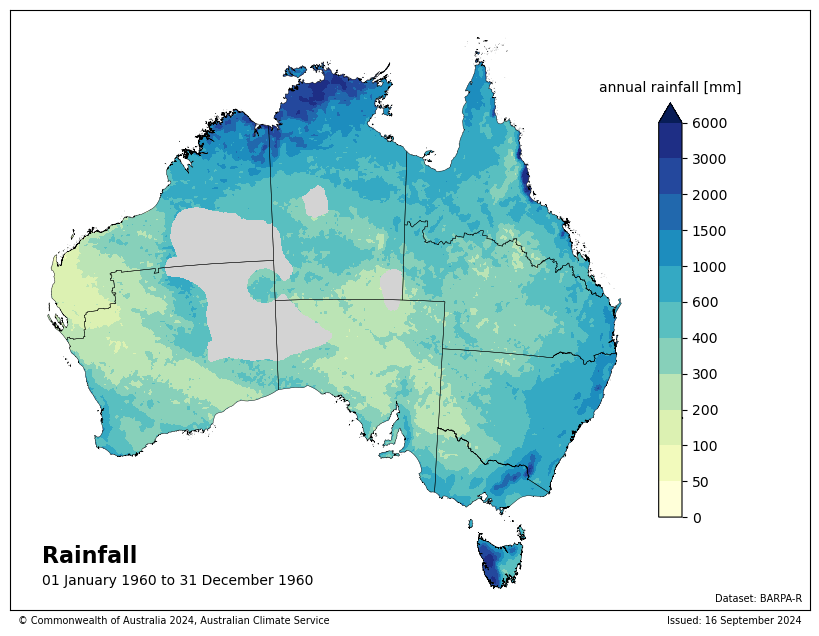

In [13]:
%%time
ds_pr = xr.open_dataset("/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/bias-adjustment-input/AGCD-05i/BOM/ACCESS-CM2/historical/r4i1p1f1/BARPA-R/v1-r1/day/pr/pr_AGCD-05i_ACCESS-CM2_historical_r4i1p1f1_BOM_BARPA-R_v1-r1_day_19600101-19601231.nc")

# annual total rainfall
da_pr_ann = ds_pr.sum(dim="time").pr

start = datetime.datetime.strptime(ds_pr.time_coverage_start, '%Y%m%dT%H%MZ').strftime("%d %B %Y")
end = datetime.datetime.strptime(ds_pr.time_coverage_end, '%Y%m%dT%H%MZ').strftime("%d %B %Y")

plot_acs_hazard(data = da_pr_ann,
                regions = regions_dict['ncra_regions'],
                cmap=cmap_dict["pr"],
                ticks=tick_dict['pr_annual'],
                cbar_label="annual rainfall [mm]",
                cbar_extend="max",
                title = "Rainfall",
                dataset_name = ds_pr.source_id,
                date_range=f"{start} to {end}",
                agcd_mask=True,
                cmap_bad="lightgrey",
                watermark="");

CPU times: user 2min 17s, sys: 704 ms, total: 2min 18s
Wall time: 2min 18s


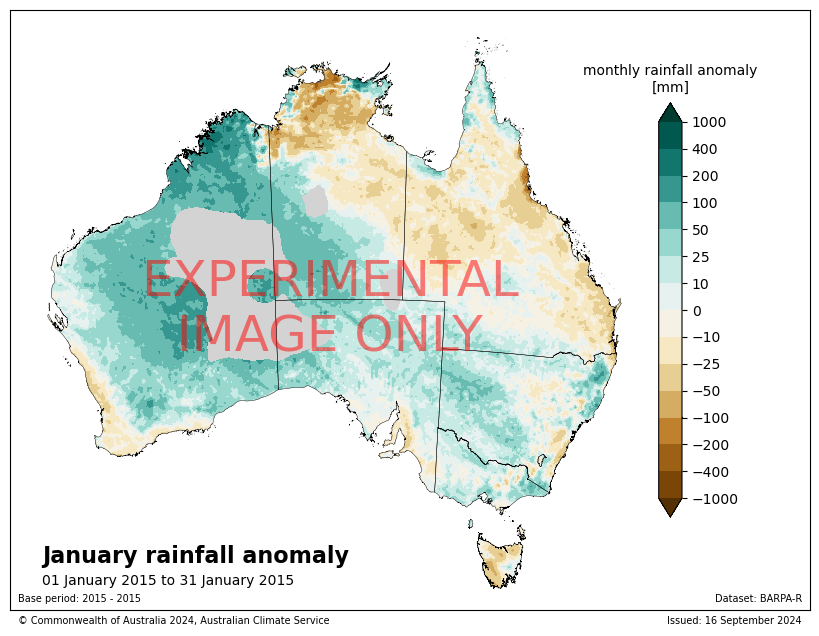

In [14]:
%%time
# Rainfall anomaly data

plot_acs_hazard(data = da_pr_anom,
                    regions = regions_dict['aus_states_territories'],
                   cmap=cmap_dict["pr_anom"],
                   ticks=tick_dict['pr_anom_mon'],
                   cbar_label="monthly rainfall anomaly\n[mm]",
                   title="January rainfall anomaly",
                   date_range=f"01 January 2015 to 31 January 2015",
                   baseline= "2015 - 2015",
                   dataset_name=ds_pr.source_id, 
                   agcd_mask=True,
                   cmap_bad="lightgrey",
                    );

In [15]:
# Temperature plots for Australia. Notice that the colorbar stays the same even though the plotted temperature ranges are different

CPU times: user 2min 8s, sys: 445 ms, total: 2min 8s
Wall time: 2min 9s


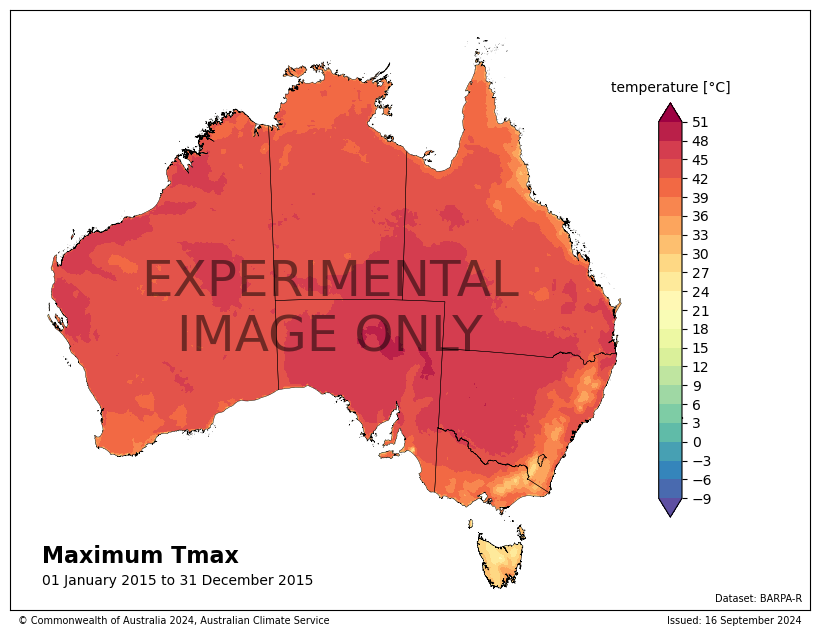

In [16]:
%%time
da_tasmax_max = ds_tasmax.tasmax.max(dim="time")

start = datetime.datetime.strptime(ds_tasmax.time_coverage_start, '%Y%m%dT%H%MZ').strftime("%d %B %Y")
end = datetime.datetime.strptime(ds_tasmax.time_coverage_end, '%Y%m%dT%H%MZ').strftime("%d %B %Y")

plot_acs_hazard(data = da_tasmax_max,
                    regions = regions_dict['aus_states_territories'],
                   cmap=cmap_dict["tas"],
                   ticks=tick_dict['tas'],
                    cbar_label="temperature [\N{DEGREE SIGN}C]",
                    title = "Maximum Tmax",
                    date_range=f"{start} to {end}",
                    dataset_name=ds_tasmax.source_id,
                    watermark_color = "k",
                   );

CPU times: user 2min 14s, sys: 502 ms, total: 2min 15s
Wall time: 2min 15s


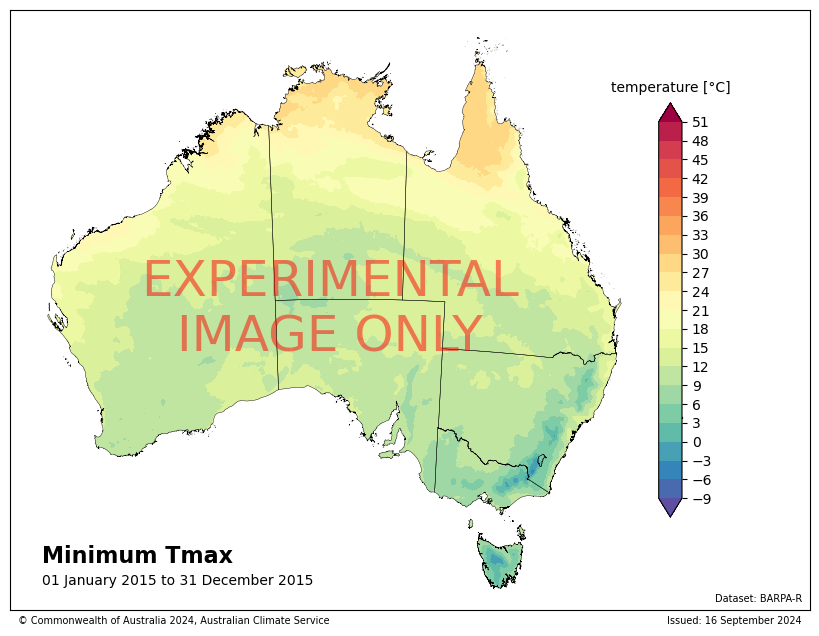

In [17]:
%%time
da_tasmax_min = ds_tasmax.tasmax.min(dim="time", keep_attrs=True)

start = datetime.datetime.strptime(ds_tasmax.time_coverage_start, '%Y%m%dT%H%MZ').strftime("%d %B %Y")
end = datetime.datetime.strptime(ds_tasmax.time_coverage_end, '%Y%m%dT%H%MZ').strftime("%d %B %Y")

plot_acs_hazard(data = da_tasmax_min,
                    regions = regions_dict['aus_states_territories'],
                   cmap=cmap_dict["tas"],
                   ticks=tick_dict['tas'],
                    cbar_label="temperature [\N{DEGREE SIGN}C]",
                    title = "Minimum Tmax",
                    date_range=f"{start} to {end}",
                    dataset_name=ds_tasmax.source_id,
                   );

In [18]:
# ocean

CPU times: user 5.37 s, sys: 483 ms, total: 5.86 s
Wall time: 7.34 s


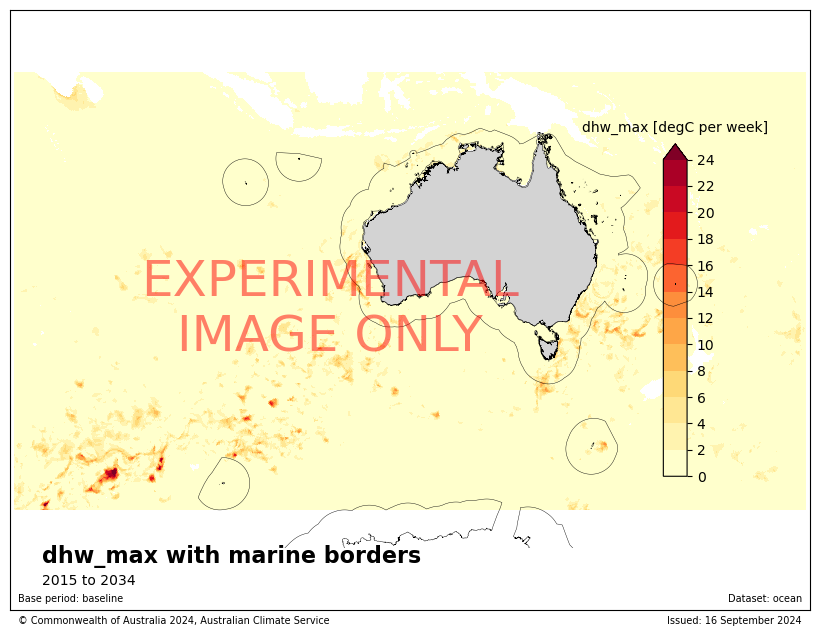

In [19]:
%%time
filename = "/g/data/ia39/ncra/ocean/GW1p5_dhw.nc"
ds = xr.open_dataset(filename)
ds = ds.rename({"xt_ocean":"lon", "yt_ocean":"lat"}) 

var = "dhw_max"
regions = regions_dict["NCRA_Marine_region"]
plot_acs_hazard(data = ds[var],
                title = "dhw_max with marine borders",
                date_range="2015 to 2034",
                regions = regions,
                cbar_extend = "max",     
                cbar_label = "dhw_max [degC per week]",
                dataset_name = "ocean",
                baseline = "baseline",
                cmap=cmap_dict['mhw_days'],
                ticks=np.arange(0,25,2),
                mask_not_australia=False,
                mask_australia=True,
                xlim = (65,180),
                ylim = (-60,0),
               savefig=False, 
               cmap_bad = "w");

CPU times: user 2min 6s, sys: 362 ms, total: 2min 6s
Wall time: 2min 8s


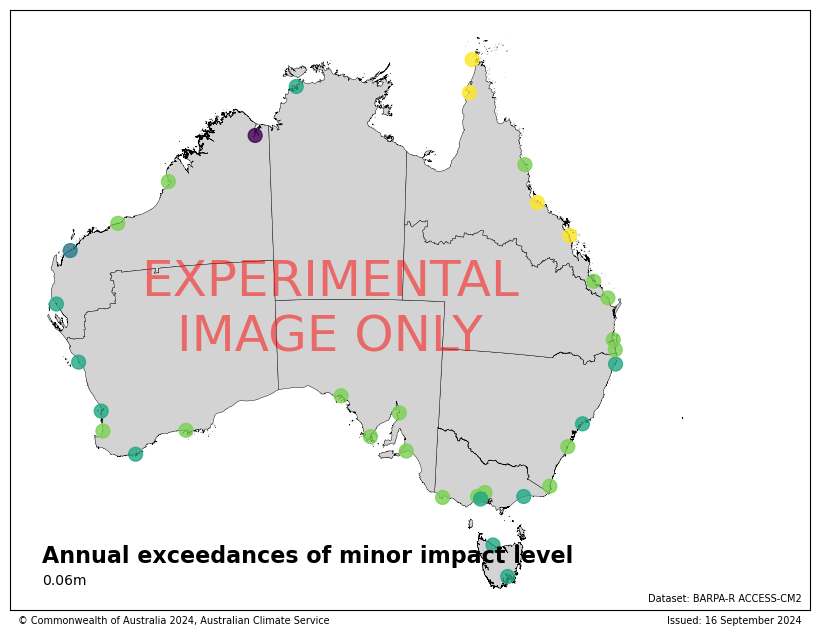

In [20]:
%%time
# station data:
df = pd.read_csv("/g/data/ia39/ncra/coastal/flood_days/annmax_exceeds_means.csv")
var = "0.06m 90th percentile"

plot_acs_hazard(station_df=df[["lat", "lon", var]],
                regions = regions_dict['ncra_regions'],
                cmap=cm.viridis_r,
                ticks=np.arange(0,18,3),
                cbar_extend="max",
                title = "Annual exceedances of minor impact level",
                date_range = "0.06m",
                cbar_label = "annual exceedances [days]",
                dataset_name = "BARPA-R ACCESS-CM2",
               facecolor="lightgrey");

In [21]:
# three panel plot


CPU times: user 2min 26s, sys: 1.04 s, total: 2min 27s
Wall time: 2min 29s


(<Figure size 1000x400 with 5 Axes>, <GeoAxes: >)

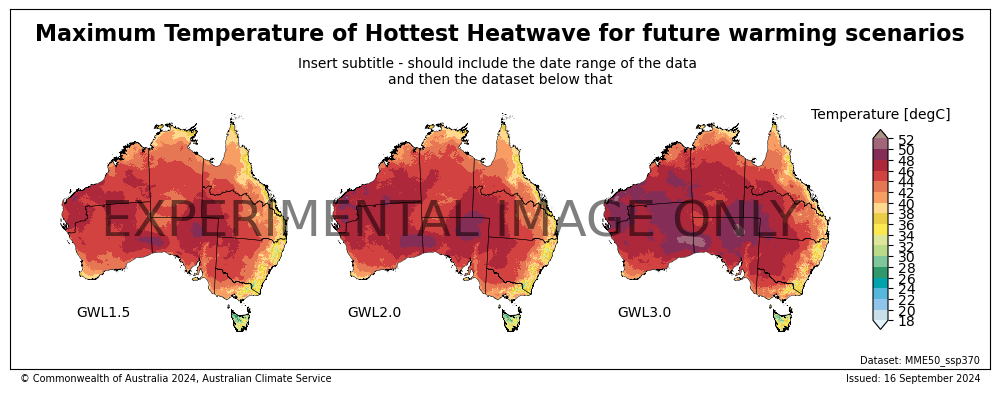

In [22]:
%%time
var = "HWAtx"

ds_gwl12 =xr.open_dataset("/g/data/ia39/ncra/heat/data/HWAtx/bias-corrected/ensemble/GWL-average/HWAtx_AGCD-05i_MME50_ssp370_v1-r1-ACS-QME-AGCD-1960-2022_GWL12.nc")
ds_gwl15 = xr.open_dataset("/g/data/ia39/ncra/heat/data/HWAtx/bias-corrected/ensemble/GWL-average/HWAtx_AGCD-05i_MME50_ssp370_v1-r1-ACS-QME-AGCD-1960-2022_GWL15.nc")
ds_gwl20 = xr.open_dataset("/g/data/ia39/ncra/heat/data/HWAtx/bias-corrected/ensemble/GWL-average/HWAtx_AGCD-05i_MME50_ssp370_v1-r1-ACS-QME-AGCD-1960-2022_GWL20.nc")
ds_gwl30 = xr.open_dataset("/g/data/ia39/ncra/heat/data/HWAtx/bias-corrected/ensemble/GWL-average/HWAtx_AGCD-05i_MME50_ssp370_v1-r1-ACS-QME-AGCD-1960-2022_GWL30.nc")

plot_acs_hazard_3pp(ds_gwl15 = ds_gwl15[var], 
                    ds_gwl20 = ds_gwl20[var],
                    ds_gwl30 = ds_gwl30[var],
                    regions = regions_dict['ncra_regions'],
                    cbar_label=f"Temperature [degC]",
                    title=f"Maximum Temperature of Hottest Heatwave for future warming scenarios", 
                    date_range = "Insert subtitle - should include the date range of the data \nand then the dataset below that", 
                    # baseline = "GWL1.2", 
                    dataset_name= "MME50_ssp370",
                    issued_date=None,
                    watermark="EXPERIMENTAL IMAGE ONLY", 
                    watermark_color="k",
                    cmap = cmap_dict["tasmax"],
                    ticks = np.arange(18,53,2),)

CPU times: user 2min 19s, sys: 721 ms, total: 2min 20s
Wall time: 2min 21s


(<Figure size 1000x400 with 5 Axes>, <GeoAxes: >)

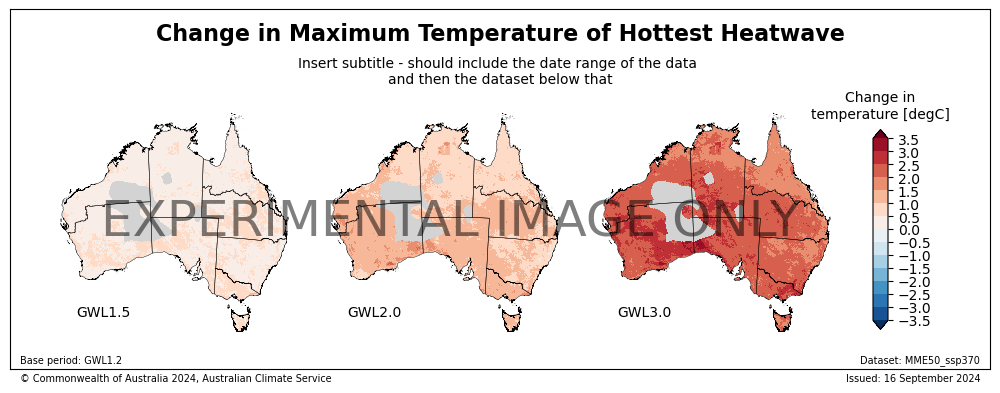

In [23]:
%%time
var = "HWAtx"

# ds_gwl12 =xr.open_dataset("/g/data/ia39/ncra/heat/data/HWAtx/bias-corrected/ensemble/GWL-average/HWAtx_AGCD-05i_MME50_ssp370_v1-r1-ACS-QME-AGCD-1960-2022_GWL12.nc")
# ds_gwl15 = xr.open_dataset("/g/data/ia39/ncra/heat/data/HWAtx/bias-corrected/ensemble/GWL-average/HWAtx_AGCD-05i_MME50_ssp370_v1-r1-ACS-QME-AGCD-1960-2022_GWL15.nc")
# ds_gwl20 = xr.open_dataset("/g/data/ia39/ncra/heat/data/HWAtx/bias-corrected/ensemble/GWL-average/HWAtx_AGCD-05i_MME50_ssp370_v1-r1-ACS-QME-AGCD-1960-2022_GWL20.nc")
# ds_gwl30 = xr.open_dataset("/g/data/ia39/ncra/heat/data/HWAtx/bias-corrected/ensemble/GWL-average/HWAtx_AGCD-05i_MME50_ssp370_v1-r1-ACS-QME-AGCD-1960-2022_GWL30.nc")

plot_acs_hazard_3pp(ds_gwl15 = ds_gwl15[var] -ds_gwl12[var], 
                    ds_gwl20 = ds_gwl20[var] -ds_gwl12[var],
                    ds_gwl30 = ds_gwl30[var] -ds_gwl12[var],
                    regions = regions_dict['ncra_regions'],
                    cbar_label=f"Change in\ntemperature [degC]",
                    title=f"Change in Maximum Temperature of Hottest Heatwave", 
                    date_range = "Insert subtitle - should include the date range of the data \nand then the dataset below that", 
                    baseline = "GWL1.2", 
                    dataset_name= "MME50_ssp370",
                    issued_date=None,
                    watermark="EXPERIMENTAL IMAGE ONLY", 
                    watermark_color="k",
                    cmap = cmap_dict["tas_anom"],
                    ticks = np.arange(-3.5,3.51,0.5),
                    agcd_mask=True,
)

## Example 3: Select areas
Plot data for selected areas/ states

In [24]:
# plot one state

CPU times: user 9.89 s, sys: 76.3 ms, total: 9.96 s
Wall time: 9.98 s


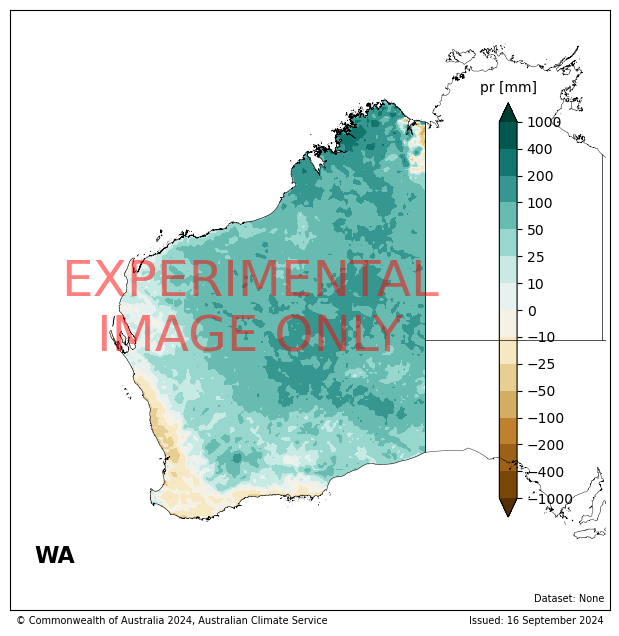

In [25]:
%%time
plot_acs_hazard(data = da_pr_anom,
                    regions = regions_dict['aus_states_territories'],
                   cmap=cmap_dict["pr_anom"],
                   ticks=tick_dict['pr_anom_mon'],
                   cbar_label="pr [mm]",
                   select_area=["Western Australia"],
                   figsize=(6,6),
                   title="WA", 
                   );

In [26]:
# PATH = "/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data"
# name = 'aus_local_gov'
# regions_dict.update(
#         {
#             name: gpd.read_file(
#                 f"{PATH}/{name}/{name}.shp"
#             )
#         }
#     )

CPU times: user 13.7 s, sys: 897 ms, total: 14.6 s
Wall time: 15.1 s


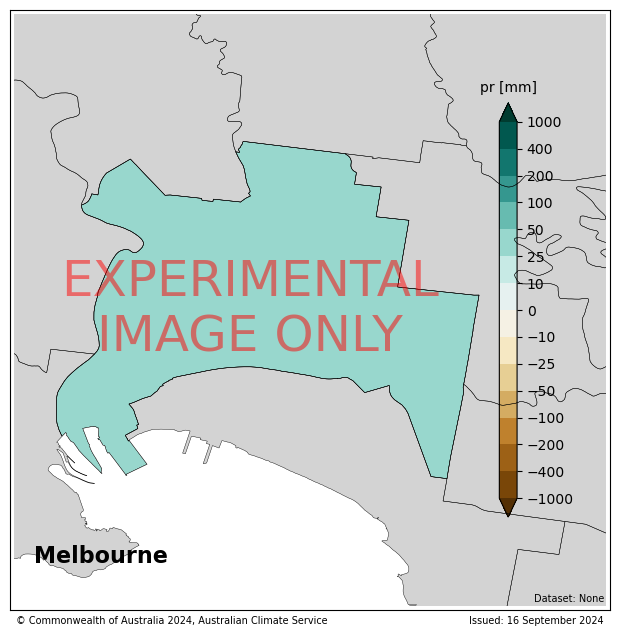

In [27]:
%%time
# Make sure that the regions is the right one for the desired areas
plot_acs_hazard(data = da_pr_anom,
                    regions = regions_dict['aus_local_gov'],
                   cmap=cmap_dict["pr_anom"],
                   ticks=tick_dict['pr_anom_mon'],
                   cbar_label="pr [mm]",
                   select_area=["Melbourne"],
                   figsize=(6,6),
                   title="Melbourne",
                   land_shadow=True,
                   );

CPU times: user 5min 1s, sys: 1.35 s, total: 5min 3s
Wall time: 5min 5s


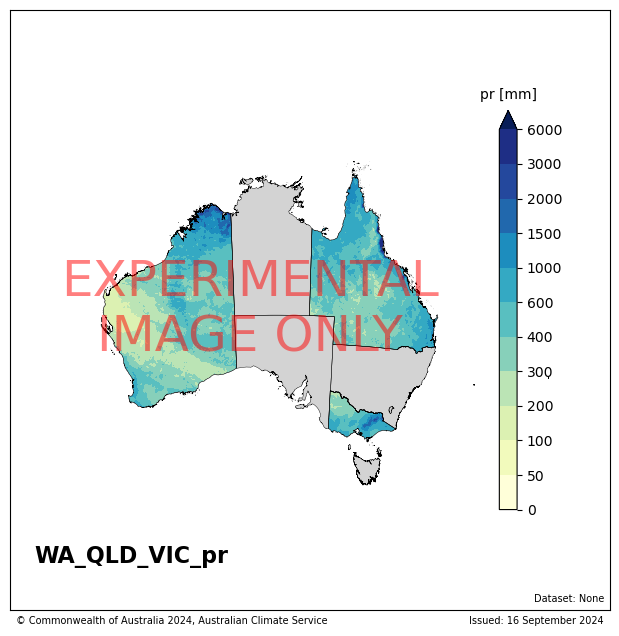

In [28]:
%%time
# select multiple non contiguous areas and show the area of non-selected australian land
regions = regions_dict['aus_states_territories']

fig, ax = plot_acs_hazard(data = da_pr_ann,
                              regions = regions,
                              cmap=cmap_dict["pr"],
                              cbar_label="pr [mm]",
                              ticks=tick_dict['pr_annual'],
                              cbar_extend="max",
                              select_area=["Victoria", "Western Australia", "Queensland"],
                              contourf=False,
                              figsize=(6,6),
                              contour=False,
                              land_shadow=True,
                              title = "WA_QLD_VIC_pr",
                              crs = ccrs.LambertConformal(central_latitude=-24.75, central_longitude=134, cutoff=30, standard_parallels=(-10, -40),),
                              )

## Example 4: loop over areas to select and plot

CPU times: user 52.7 s, sys: 397 ms, total: 53.1 s
Wall time: 55 s


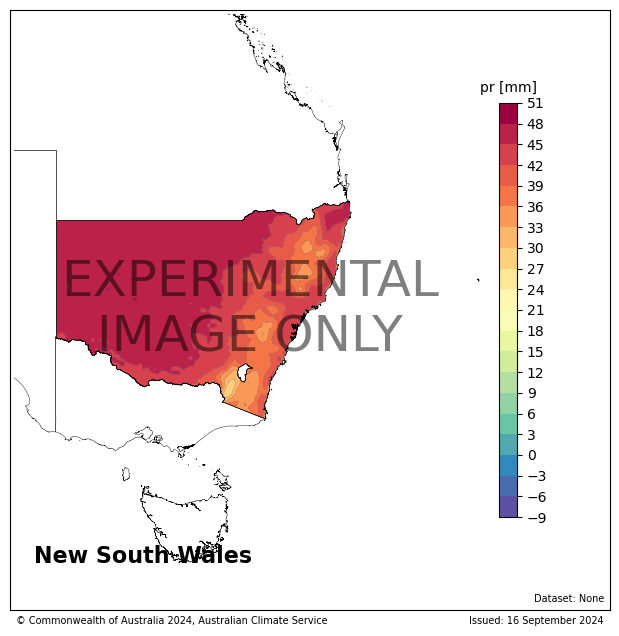

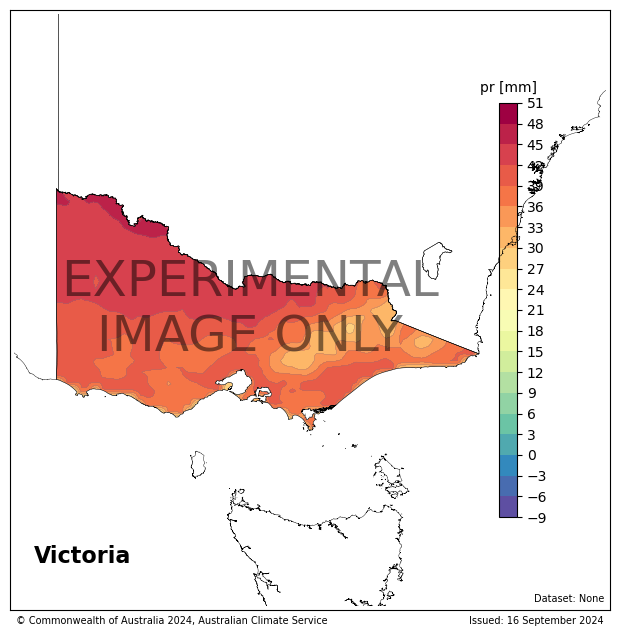

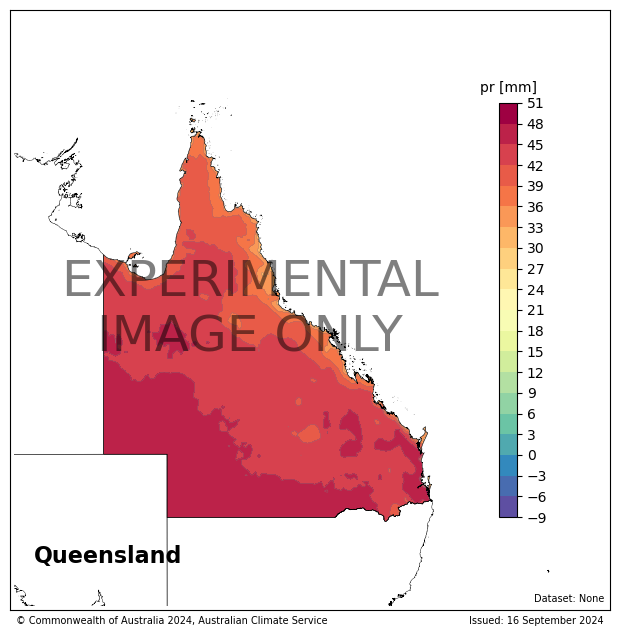

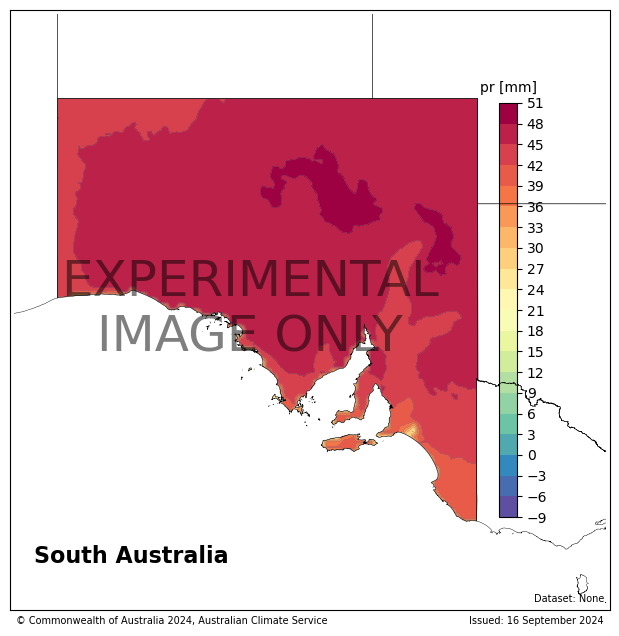

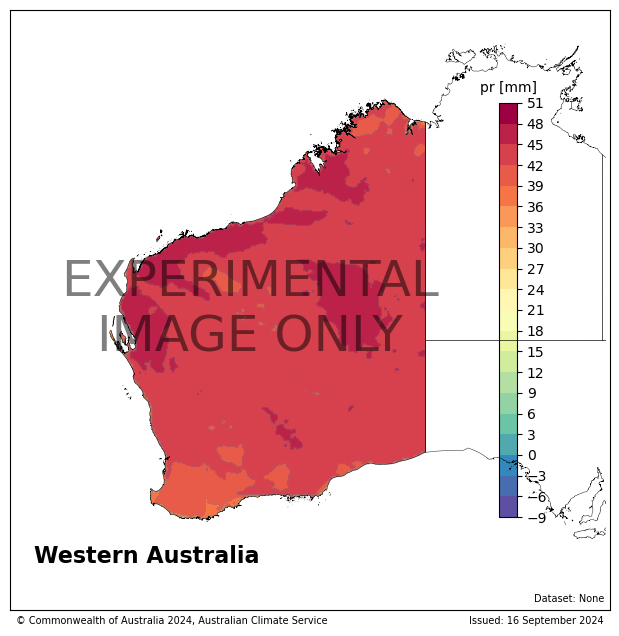

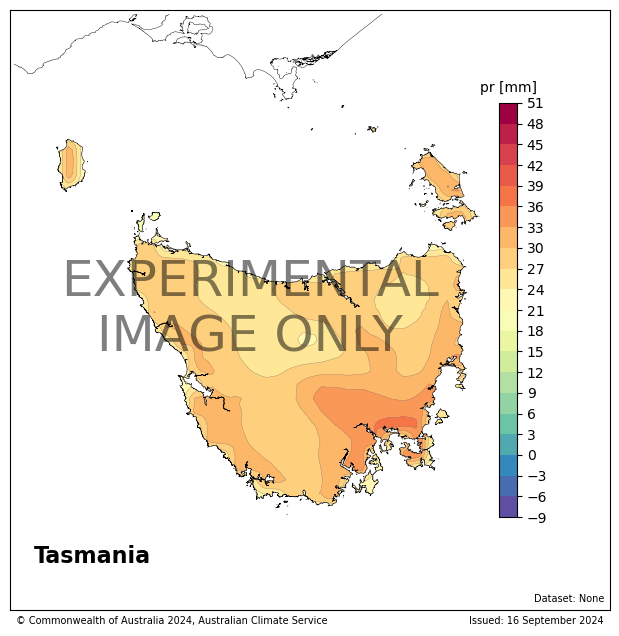

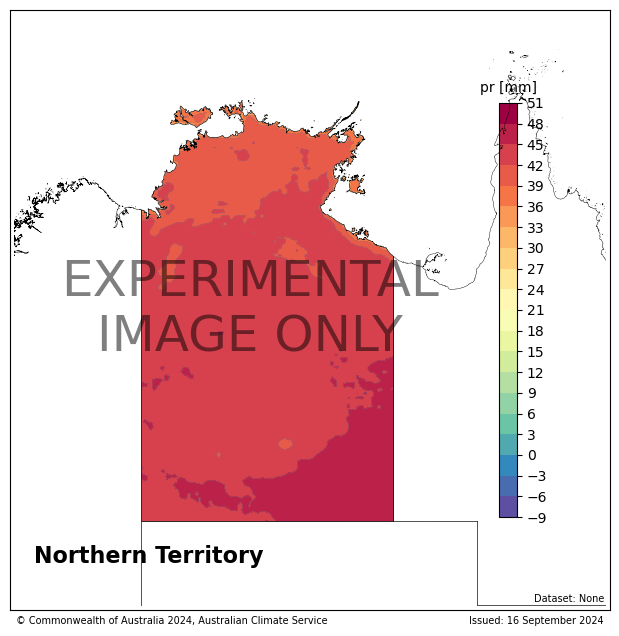

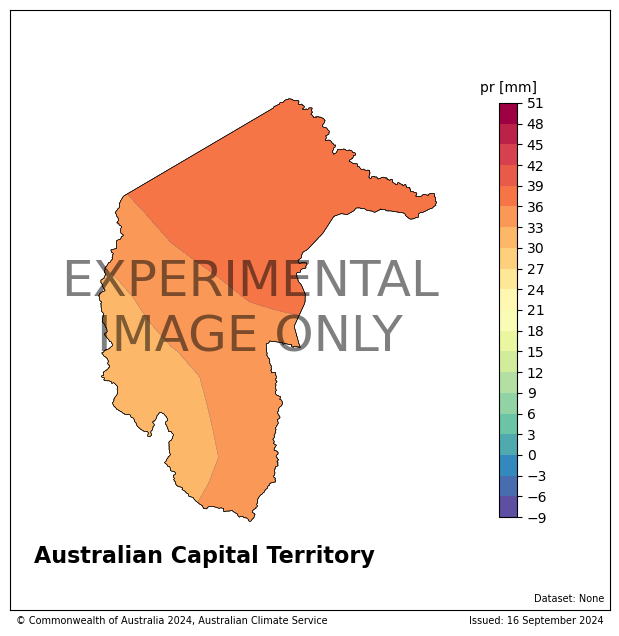

In [29]:
%%time
# loop over list of areas to cut out and make plots
regions = regions_dict['aus_states_territories']

da_tasmax_max = ds_tasmax.tasmax.max(dim="time")

for state in list(regions.STE_NAME21)[:-1]:
    plot_acs_hazard(data = da_tasmax_max,
                        figsize=(6,6),
                        regions = regions,
                       cmap=cmap_dict["tas"],
                       ticks=tick_dict['tas'],
                       cbar_label="pr [mm]",
                       cbar_extend = "both",
                       contour=True,
                       select_area=[state],
                       title=state,
                   watermark_color = "k",
                    land_shadow=False,
                   contourf=True);
